# Digging further: Percentage double-scored

In this notebook we look how PRMSE depends on % double-scored responses. 
We pick 100 rater pairs, sample different % of double-scored responses and compute PRMSE. 

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import itertools
import numpy as np

import json

from rsmtool.utils.prmse import prmse_true

from matplotlib import pyplot as plt

from pathlib import Path

%matplotlib inline

In [2]:
# let's define some settings and read the data
config = json.load(open('settings.json'))
fig_dir = Path('../paper_overleaf/figures')
df = pd.read_csv('../data/data.csv')
df_raters = pd.read_csv('../data/raters.csv')
metrics_dict = json.load(open('metrics_dict.json')) # the dictionary with metrics name we'll use for plots
df['system'] = df[config['sample_system']] # we use one sample system as defined in the config

In [3]:
human_columns = df_raters['rater_id'].values

In [4]:
# generate pairs of raters for each group

def generate_rater_pairs_for_group(df_group, n_pairs):
    raters = df_group['rater_id']
    # get all possible rater pairs
    rater_pairs = ['{}+{}'.format(p[0], p[1]) for p in itertools.combinations(raters, 2)]
    np.random.seed(100)
    selected_pairs = np.random.choice(rater_pairs, n_pairs, replace=False)
    return selected_pairs

In [5]:
# randomly sample 50 pairs for each group
selected_pairs = df_raters.groupby('category').apply(generate_rater_pairs_for_group, n_pairs=50)
pair_dict = selected_pairs.to_dict()

In [6]:
# we make one long DF to speed up computation
data = []
for c in df_raters['category'].unique():
    pairs = pair_dict[c]
    for p in pairs:
        (h1, h2) = p.split('+')
        df_p = pd.DataFrame({'pair': p,
                              'h1': df[h1],
                              'h2': df[h2],
                              'system': df['system'], 
                              'true': df['true'],
                              'category': c})
        data.append(df_p)
    df_long = pd.concat(data)

In [7]:
# let's now create a DF with different percentage double-scored
perc_double_scored = [1, 10, 25, 50, 75, 90, 100]
# we now create a df with this values
np.random.seed(123)
df_list = []
for p in perc_double_scored:
    print(p)
    to_sample = int(p/100*len(df_long))
    mask  = np.zeros(len(df_long), dtype=int)
    mask[: to_sample]=1
    np.random.shuffle(mask)
    mask = mask.astype(bool)
    df_double = df_long[mask].copy()
    df_single = df_long[~mask].copy()
    df_double['percentage'] = p
    df_single['percentage'] = p
    df_single['h2'] = None
    df_list.extend([df_double, df_single])
df_perc = pd.concat(df_list)
df_perc['h1'] = pd.to_numeric(df_perc['h1'], errors='coerce')
df_perc['h2'] = pd.to_numeric(df_perc['h2'], errors='coerce')

1
10
25
50
75
90
100


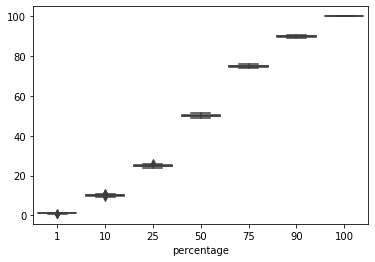

In [8]:
# A sanity check plot
sns.boxplot(data=df_perc.groupby(['pair', 'percentage']).apply(lambda x: len(x[~x['h2'].isnull()])/len(x)*100).unstack())

In [10]:
# now let's compute prmse. This can take a lot of time since we are computing over a large amount of data:
# 200 pairs, 7 percentage points. 
df_prmse  = df_perc.groupby(['pair', 'percentage']).apply(lambda x: prmse_true(x['system'],
                                                                               x[['h1', 'h2']])).reset_index()

In [11]:
df_prmse.columns = ['pair', 'percentage', 'prmse']

Text(0.5, 0, 'Percentage double-scored')

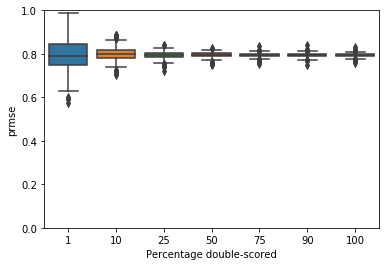

In [12]:
ax = sns.boxplot(x='percentage', y='prmse', data=df_prmse)
ax.set_ylim([0, 1]);
ax.set_xlabel("Percentage double-scored")

In [13]:
#let's also look at system correlations
df_perc['h_mean'] = df_perc[['h1', 'h2']].mean(axis=1)
df_system_corr = df_perc.groupby(['pair', 'percentage'])[['h_mean', 'system']].corr().unstack().reset_index()
df_system_corr.columns = ['-'.join(col) if col[1] !='' else col[0] for col in df_system_corr.columns]

Text(0.5, 0, 'Percentage double-scored')

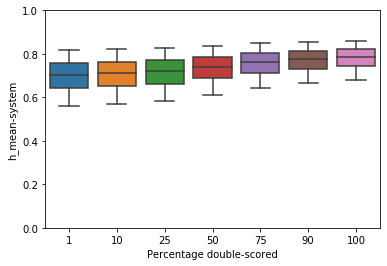

In [14]:
ax = sns.boxplot(x='percentage', y='h_mean-system', data=df_system_corr)
ax.set_ylim([0, 1]);
ax.set_xlabel("Percentage double-scored")